In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

from zipline import run_algorithm
from zipline.api import (
    attach_pipeline,
    date_rules,
    order_target_percent,
    pipeline_output,
    record,
    symbols,
    schedule_function,
    symbol,
    time_rules,
    get_open_orders,
)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import SimpleMovingAverage
from zipline.pipeline.data import USEquityPricing

import pyfolio as pf

In [ ]:
zipline.pipeline.

In [ ]:
import os

from zipline.utils.run_algo import load_extensions

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

In [ ]:
import os
os.chdir('C:\\Users\\avi\\.zipline\\csv\\yahoo')

In [4]:
# import yfinance as yf
# for symbol in ["SPY", "EFA", "IEF", "VNQ", "GSG","AAPL","MSFT"]:
# # for symbol in ["MSFT"]:
#     data = yf.download(symbol, multi_level_index=False)
#     data = data.loc[data.index > '1999-01-01']
#     data.to_csv('%s.csv'%symbol)
    

In [ ]:
# set YAHOO_CSVDIR=/path/to/csvdir 
# zipline ingest -b yahoo_csv

In [30]:
def initialize(context):
    context.stocks = [
#     context.symbols = [
        symbol("SPY"),
        symbol("EFA"),
        symbol("IEF"),
        symbol("VNQ"),
        symbol("GSG"),
    ]
#     context.stocks = symbols("SPY", "EFA", "IEF", "VNQ", "GSG")    
    #SPY - S&P 500 ETF Trust
    #EFA - MSCI EAFE ETF
    #IEF - 10 Year Treasury Bond ETF
    #VNQ - Vanguard Real Estate Index Fund ETF
    #GSG - S&P GSCI Commodity-Indexed Trust ETF    
    
    context.sma = {}
    context.period = 10 * 21

    #for asset in context.symbols: 
#     for asset in context.stocks: 
#         context.sma[asset] = SimpleMovingAverage(
#             inputs=[USEquityPricing.close],
#             window_length=context.period
#         )
    
    
    #The rebalance method will be called for every single month_start with the prices 1
    #min after the market opens
    schedule_function(
        #func=rebalance,
        func=handle_data,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open(minutes=1),
    )

    context.set_commission(
        commission.PerShare(cost=0.01, min_trade_cost=1.00)
    )
    context.set_slippage(slippage.VolumeShareSlippage())

The logic is straightforward: For each ETF representing an asset class, calculate the 10-
month simple moving average using the closing price.
This is a long-term strategy that rebalances at the market open on the first day of the
month. Zipline’s schedule function makes it simple to set this up. Note we schedule a
function called rebalance to run on this schedule. 

In [22]:
# def rebalance(context, data):
#     price_hist = data.history(context.stock, "close", context.rolling_window, "1d")
#     longs = [
#         asset
#         for asset in context.stocks
#         if data.current(asset, "price") > context.sma[asset].mean()
            
#         #if data.current(asset, "Close") > context.sma[asset].mean()
#     ]

#     for asset in context.portfolio.positions:
#         if asset not in longs and data.can_trade(asset):
#             order_target_percent(asset, 0)

#     for asset in longs:
#         if data.can_trade(asset):
#             order_target_percent(asset, 1.0 / len(longs))

In [31]:
def handle_data(context, data):
    longs = []
    for asset in context.stocks:
        
        price_hist = data.history(asset, "close", context.period, "1d")  
        
        #rolling_mean_short_term = price_hist.rolling(window=45, center=False).mean()
        rolling_mean = price_hist.rolling(window=context.period, center=False).mean()
        #print(price_hist[-1], rolling_mean)
        if price_hist[-1] > rolling_mean[-1]:
            longs.append(asset)  
    #print(longs)
    for asset in context.portfolio.positions:
        if asset not in longs and data.can_trade(asset):
            order_target_percent(asset, 0)

    for asset in longs:
        if data.can_trade(asset):
            order_target_percent(asset, 1.0 / len(longs))
    

In [32]:
def analyze(context, perf): 
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
    #pf.create_full_tear_sheet(returns,positions=positions,transactions=transactions,round_trips=True)
    #pf.create_full_tear_sheet(returns, benchmark_rets = None)
    pf.create_full_tear_sheet(returns,positions=positions,transactions=transactions,benchmark_rets = None)

On the first trading day of every month, the logic checks if the current price is greater than
the 10-month simple moving average. If so, it adds the symbol to a list.
The next step sets a target of 0% for those assets with a price that does not exceed the 10-
month simple moving average.
Finally, we equal-weight the portfolio with the ETFs that are trending

In [28]:
# ######### The below code is just a test to check yahoo csv ingest ##################### 
# %matplotlib inline

# from zipline import run_algorithm 
# from zipline.api import order_target_percent, symbol, set_commission
# from zipline.finance.commission import PerTrade
# import pandas as pd
# import pyfolio as pf

# import warnings
# warnings.filterwarnings('ignore')

# def initialize(context): 
#     context.stock = symbol('AAPL')
#     context.rolling_window = 90
#     set_commission(PerTrade(cost=5))     

# def handle_data(context, data): 
#     price_hist = data.history(context.stock, "close", context.rolling_window, "1d")          
    
#     rolling_mean_short_term = price_hist.ewm(span=5,adjust=True,ignore_na=True).mean()
#     rolling_mean_long_term = price_hist.ewm(span=30,adjust=True,ignore_na=True).mean()
    
#     if rolling_mean_short_term[-1] > rolling_mean_long_term[-1]:
#         order_target_percent(context.stock, 1.0)     
#     elif rolling_mean_short_term[-1] < rolling_mean_long_term[-1]:
#         order_target_percent(context.stock, 0.0)     

# def analyze(context, perf): 
#     returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf) 
#     #pf.create_returns_tear_sheet(returns, benchmark_rets = None)
#     pf.create_returns_tear_sheet(returns,positions=positions,transactions=transactions, benchmark_rets = None)
    
# # start_date = pd.to_datetime('2000-1-1', utc=True)
# # end_date = pd.to_datetime('2018-1-1', utc=True)
# start_date = pd.Timestamp('2000-1-1')
# end_date = pd.Timestamp('2018-1-1')
    
# results = run_algorithm(start = start_date, end = end_date, initialize = initialize, 
#                         analyze = analyze, handle_data = handle_data, capital_base = 10000, 
#                         data_frequency = 'daily', 
#                         #bundle ='quandl'
#                         bundle ='yahoo_csv'
#                        )

In [ ]:
# pd.read_csv('SPY.csv')

Start date,2010-01-04
End date,2023-06-30
Total months,161
,Backtest
Annual return,3.7%
Cumulative returns,62.4%
Annual volatility,12.4%
Sharpe ratio,0.35
Calmar ratio,0.12
Stability,0.73
Max drawdown,-31.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.00,2022-03-08,2022-11-09,NaT,NaN
1,18.18,2015-03-23,2016-11-04,2019-10-30,1203
2,17.06,2011-04-29,2011-11-11,2014-06-18,819
3,11.08,2010-04-14,2010-07-06,2010-10-13,131
4,9.90,2020-02-14,2020-03-18,2020-08-12,129


Top 10 long positions of all time,max
sid,
IEF,151.75%
GSG,102.10%
EFA,101.10%
SPY,100.84%
VNQ,100.74%


Top 10 short positions of all time,max
sid,
VNQ,-49.70%
EFA,-33.34%
IEF,-33.23%
GSG,-32.95%


Top 10 positions of all time,max
sid,
IEF,151.75%
GSG,102.10%
EFA,101.10%
SPY,100.84%
VNQ,100.74%


TypeError: datetime64 type does not support sum operations

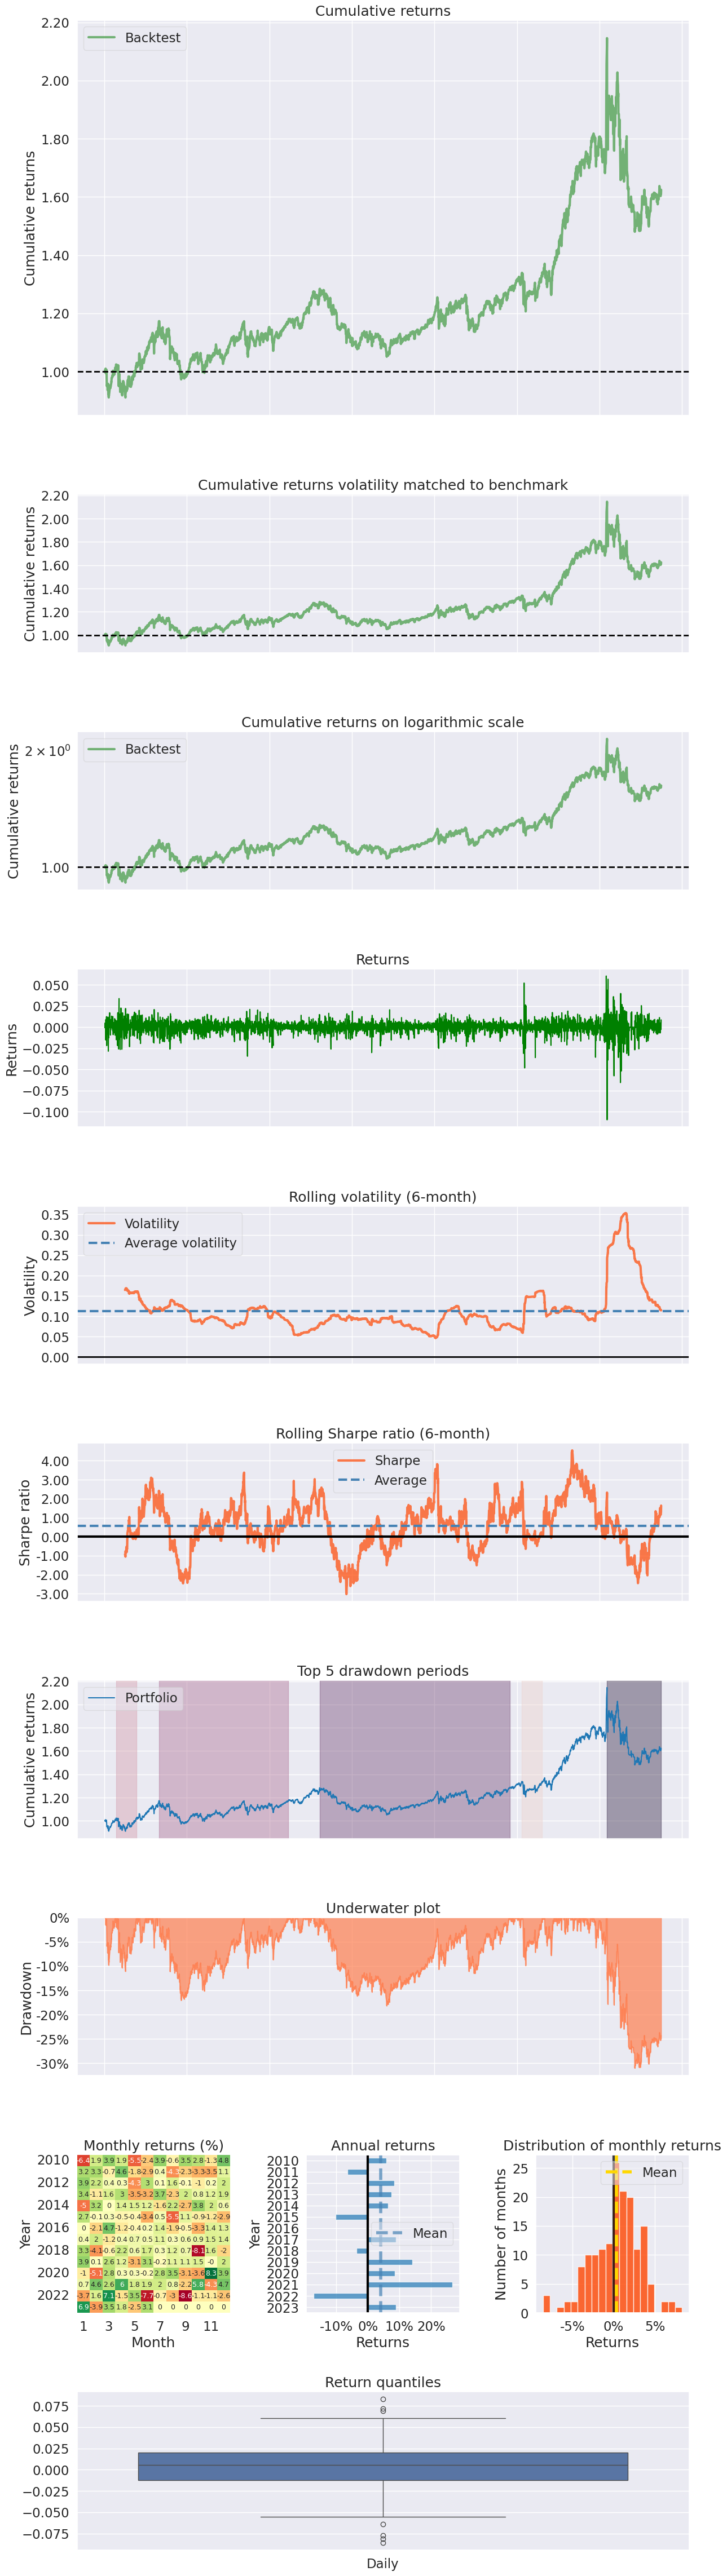

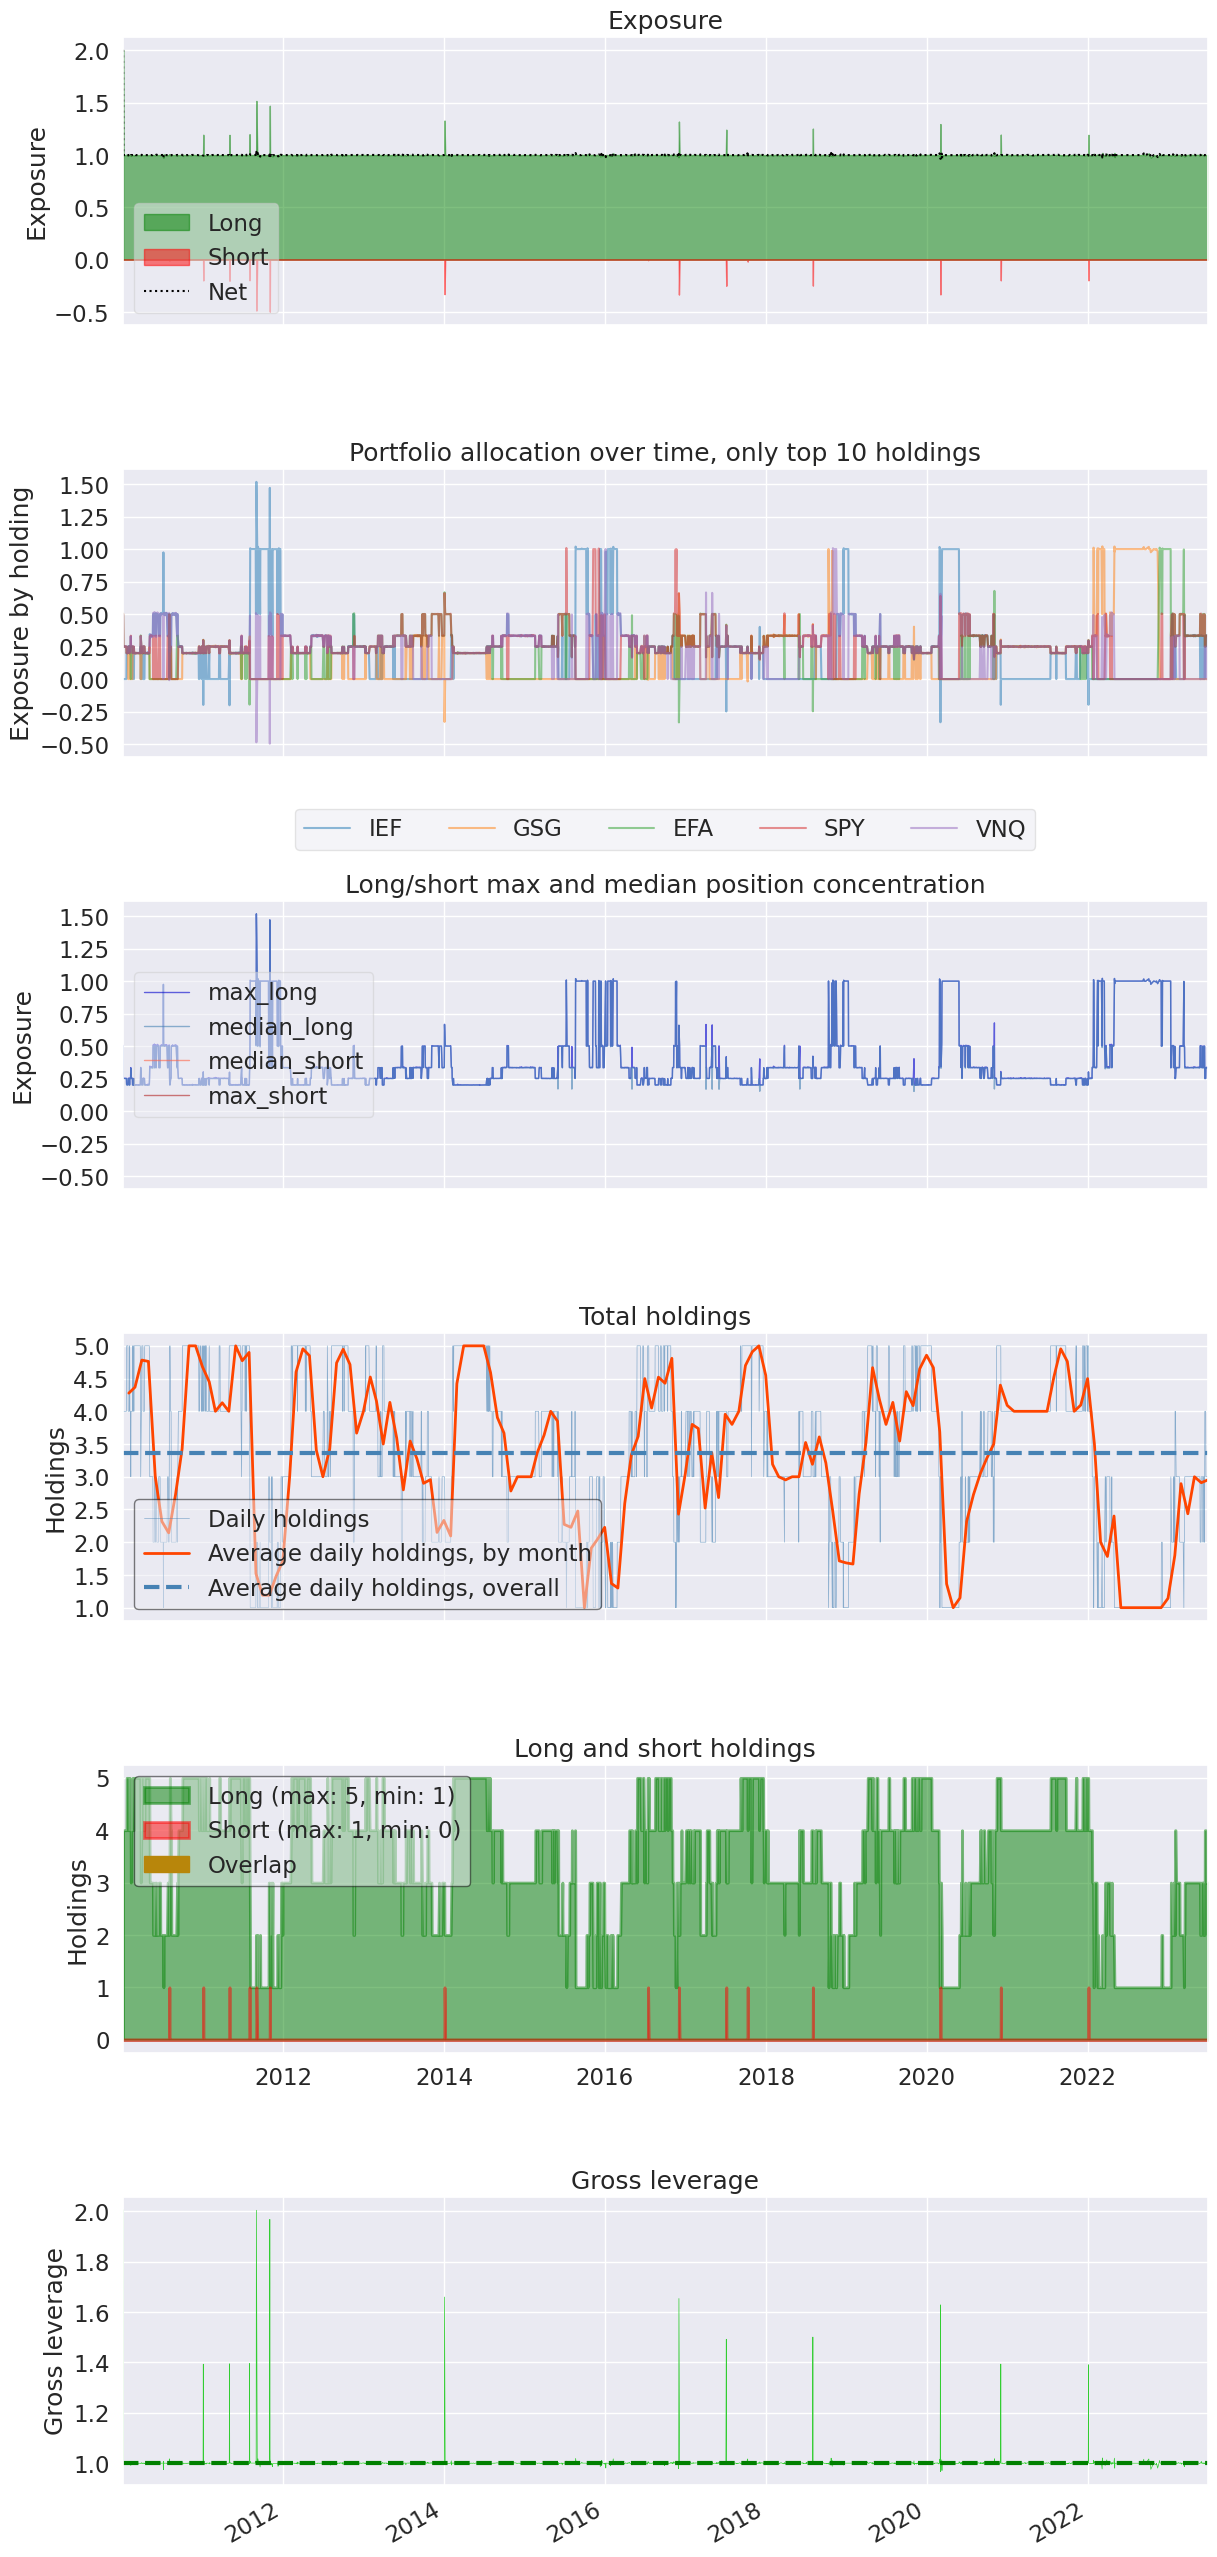

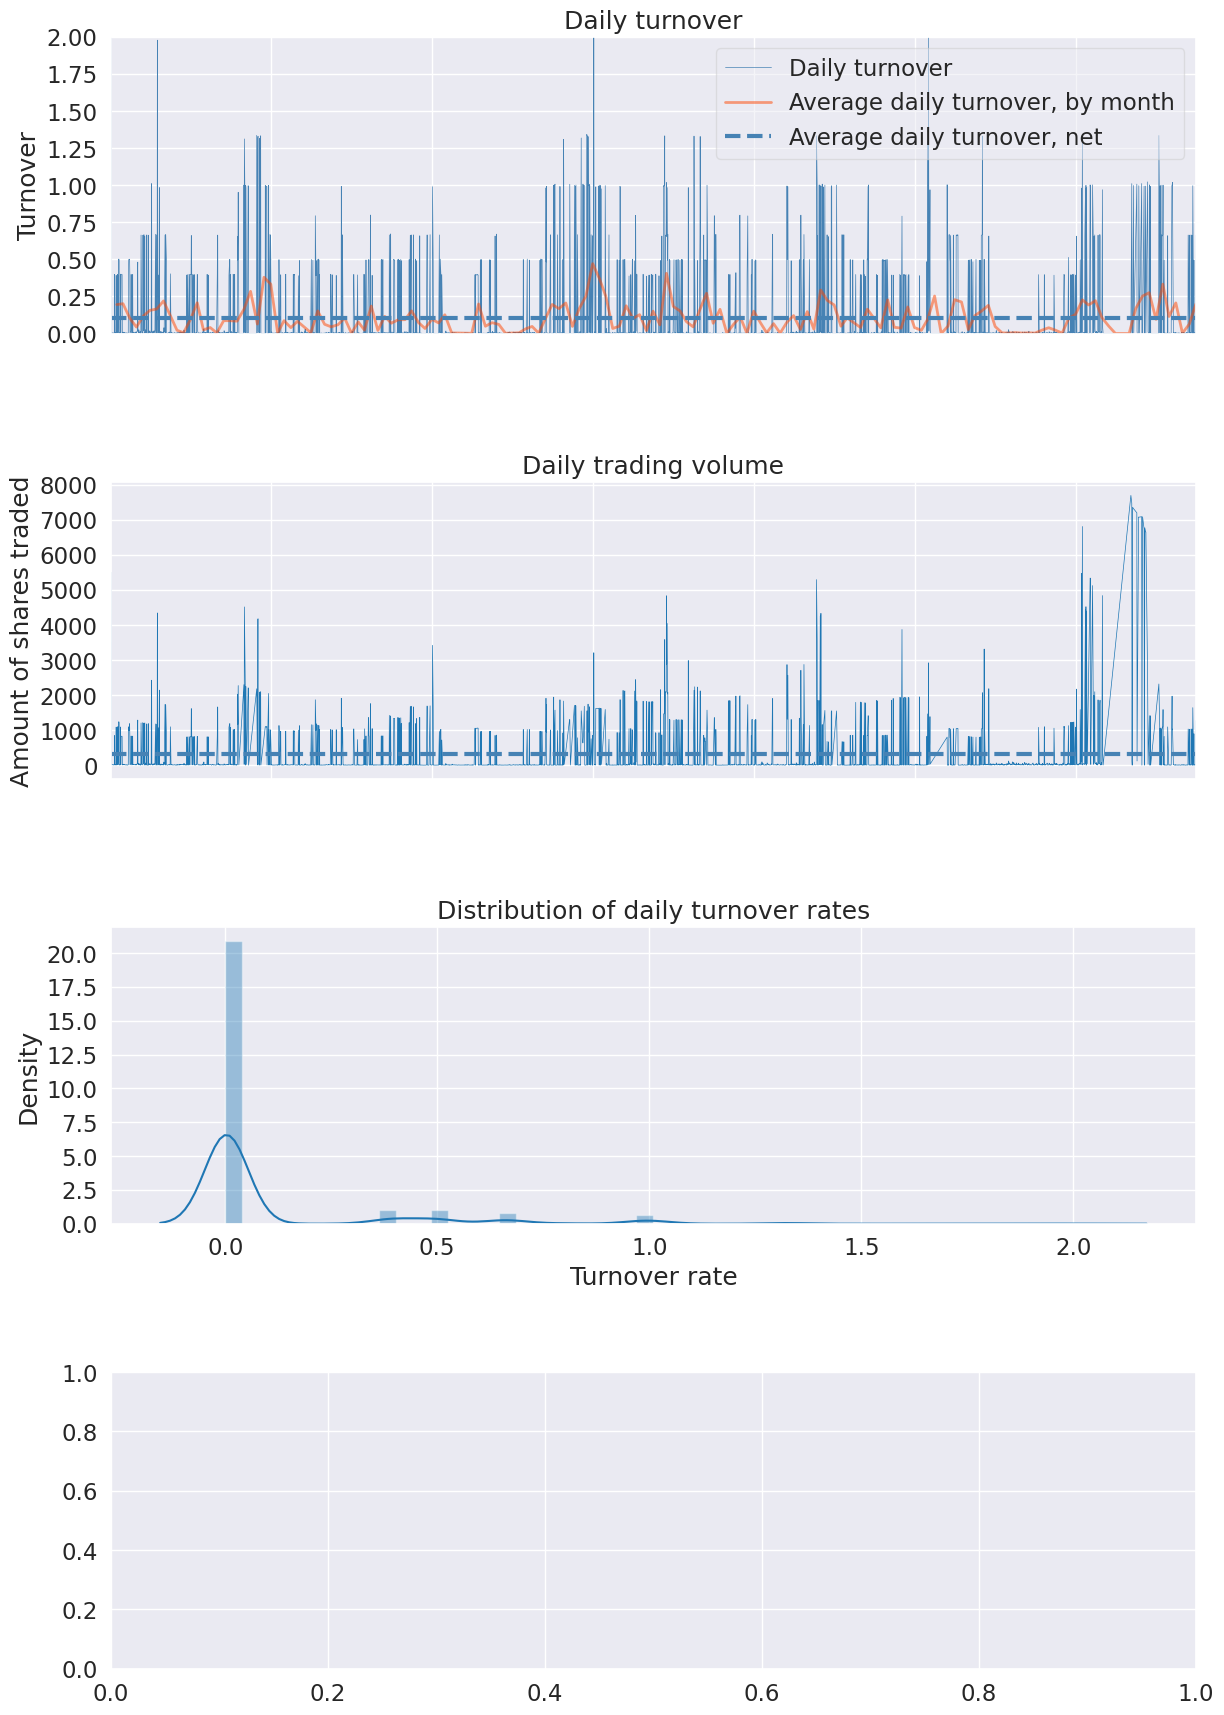

In [33]:
start = pd.Timestamp("2010")
end = pd.Timestamp("2023-06-30")

perf = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    handle_data = handle_data,
    analyze = analyze,
    capital_base = 100000,
    data_frequency = 'daily',
#     bundle="quantopian-quandl"
#     bundle="quandl",
#     bundle="yahoo_direct"
    bundle = "yahoo_csv"
)

Start date,2010-01-04
End date,2023-06-30
Total months,161
,Backtest
Annual return,3.7%
Cumulative returns,62.4%
Annual volatility,12.4%
Sharpe ratio,0.35
Calmar ratio,0.12
Stability,0.73
Max drawdown,-31.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.00,2022-03-08,2022-11-09,NaT,NaN
1,18.18,2015-03-23,2016-11-04,2019-10-30,1203
2,17.06,2011-04-29,2011-11-11,2014-06-18,819
3,11.08,2010-04-14,2010-07-06,2010-10-13,131
4,9.90,2020-02-14,2020-03-18,2020-08-12,129


Top 10 long positions of all time,max
sid,
IEF,151.75%
GSG,102.10%
EFA,101.10%
SPY,100.84%
VNQ,100.74%


Top 10 short positions of all time,max
sid,
VNQ,-49.70%
EFA,-33.34%
IEF,-33.23%
GSG,-32.95%


Top 10 positions of all time,max
sid,
IEF,151.75%
GSG,102.10%
EFA,101.10%
SPY,100.84%
VNQ,100.74%


TypeError: datetime64 type does not support sum operations

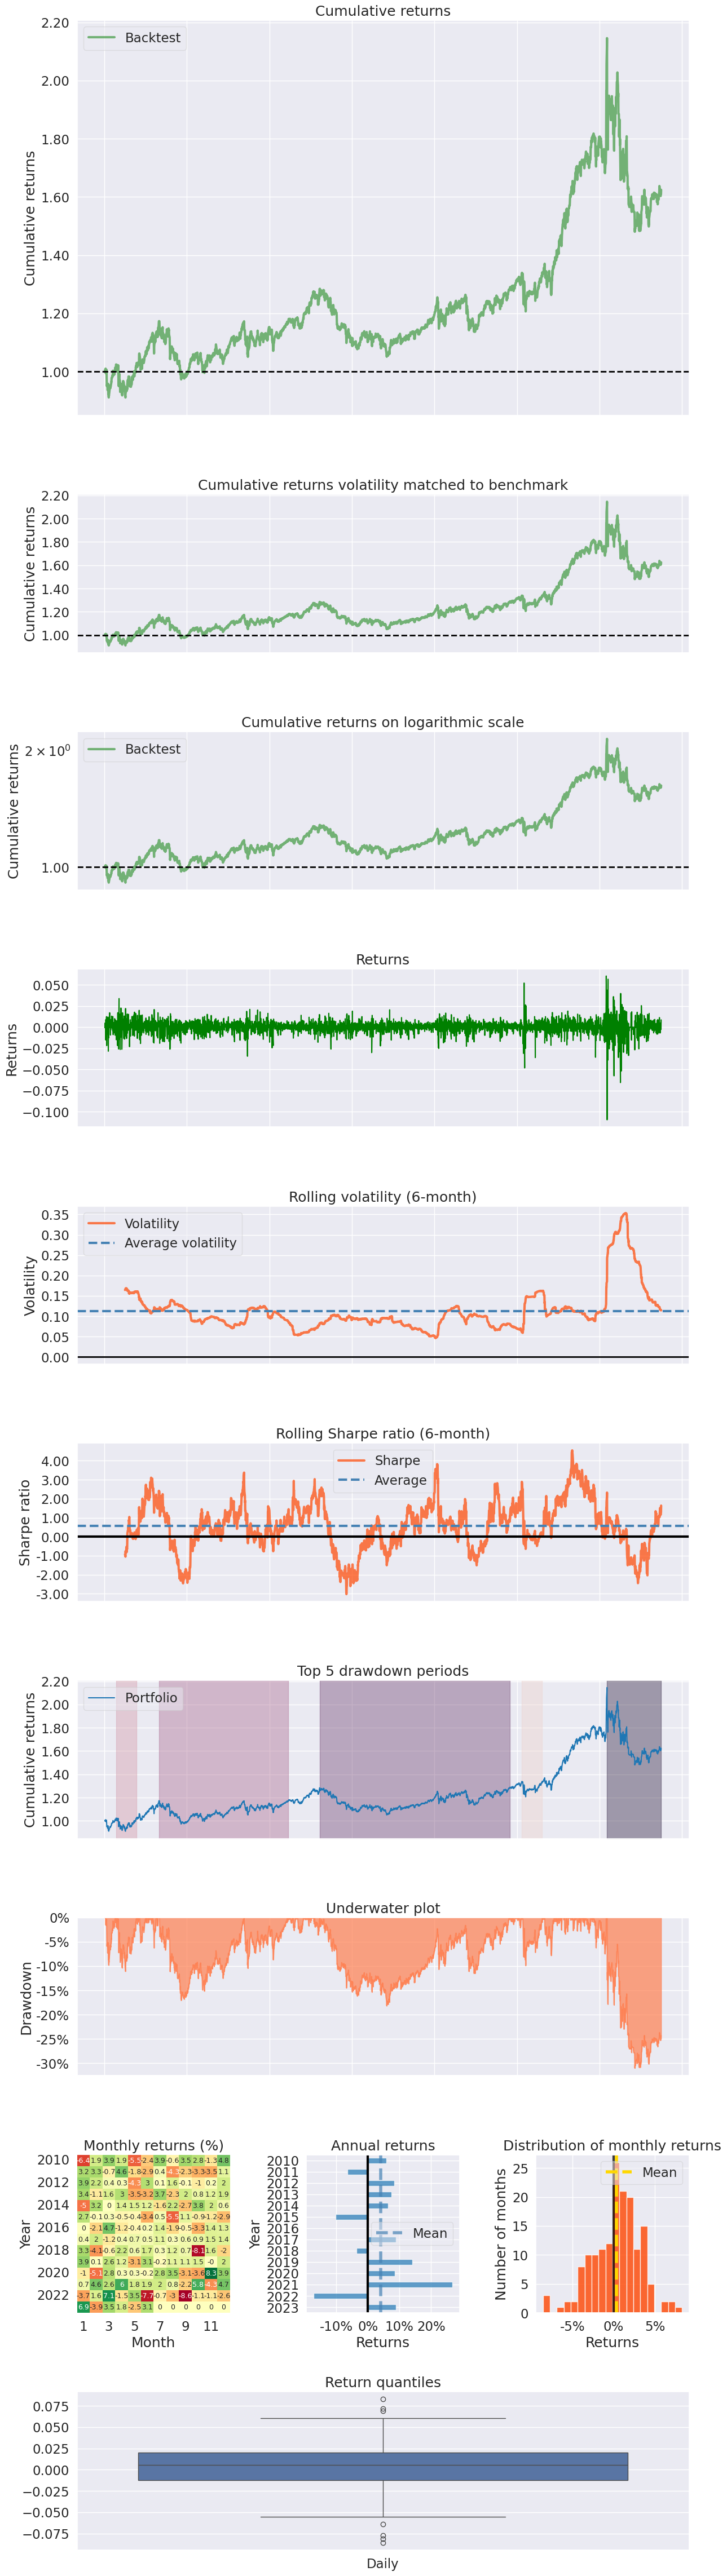

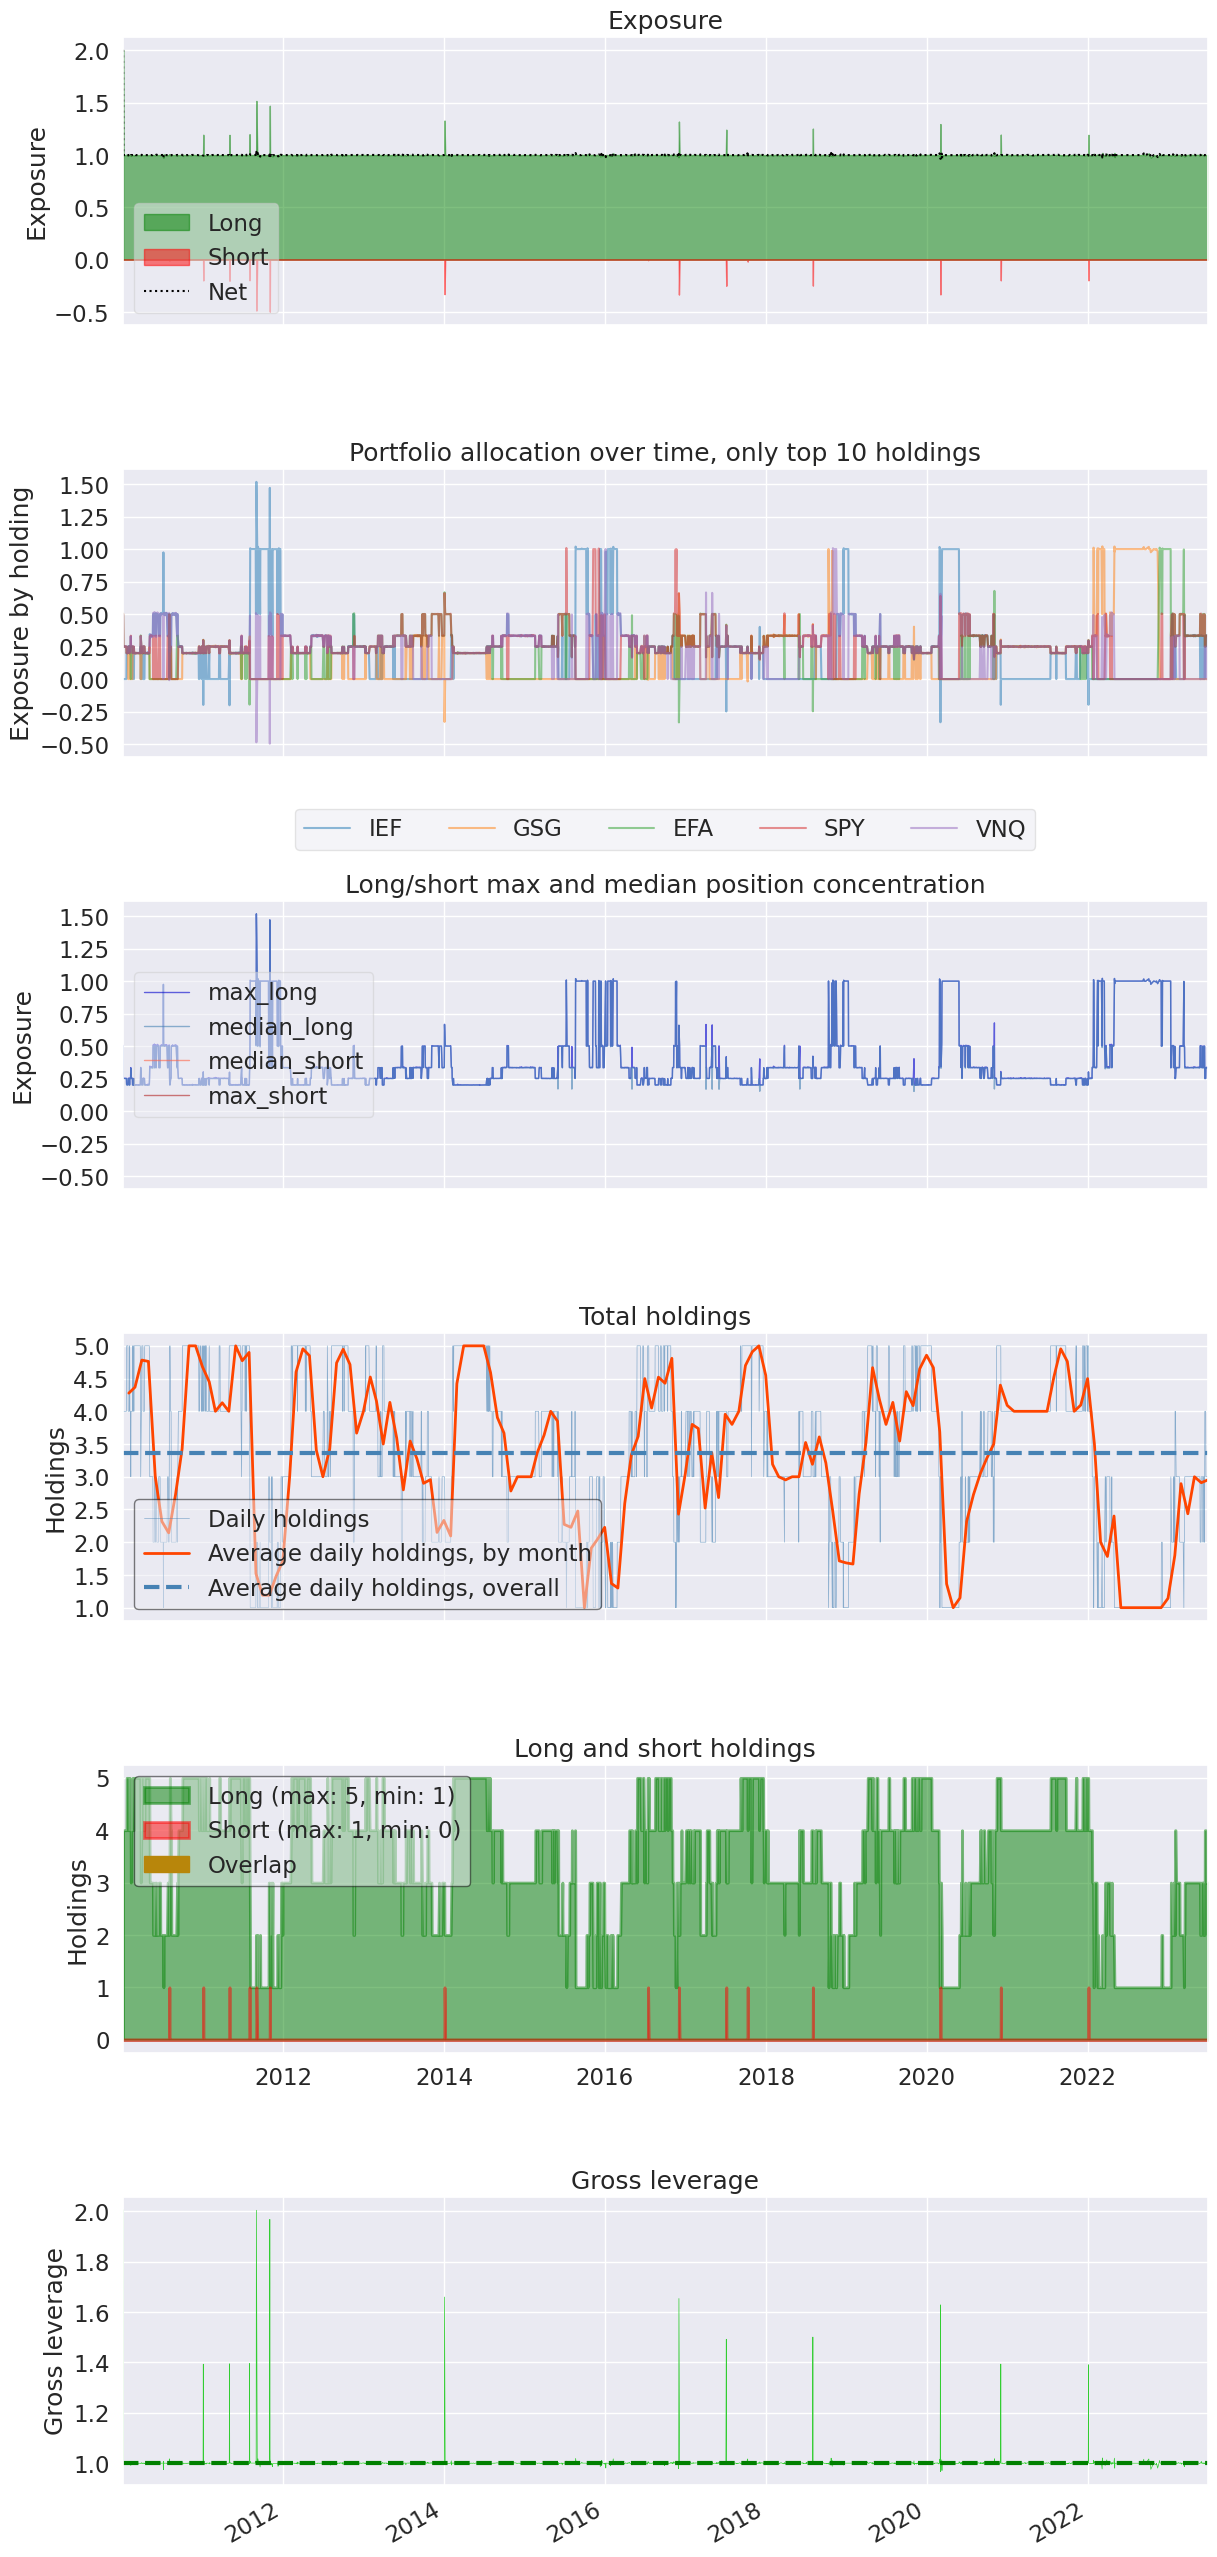

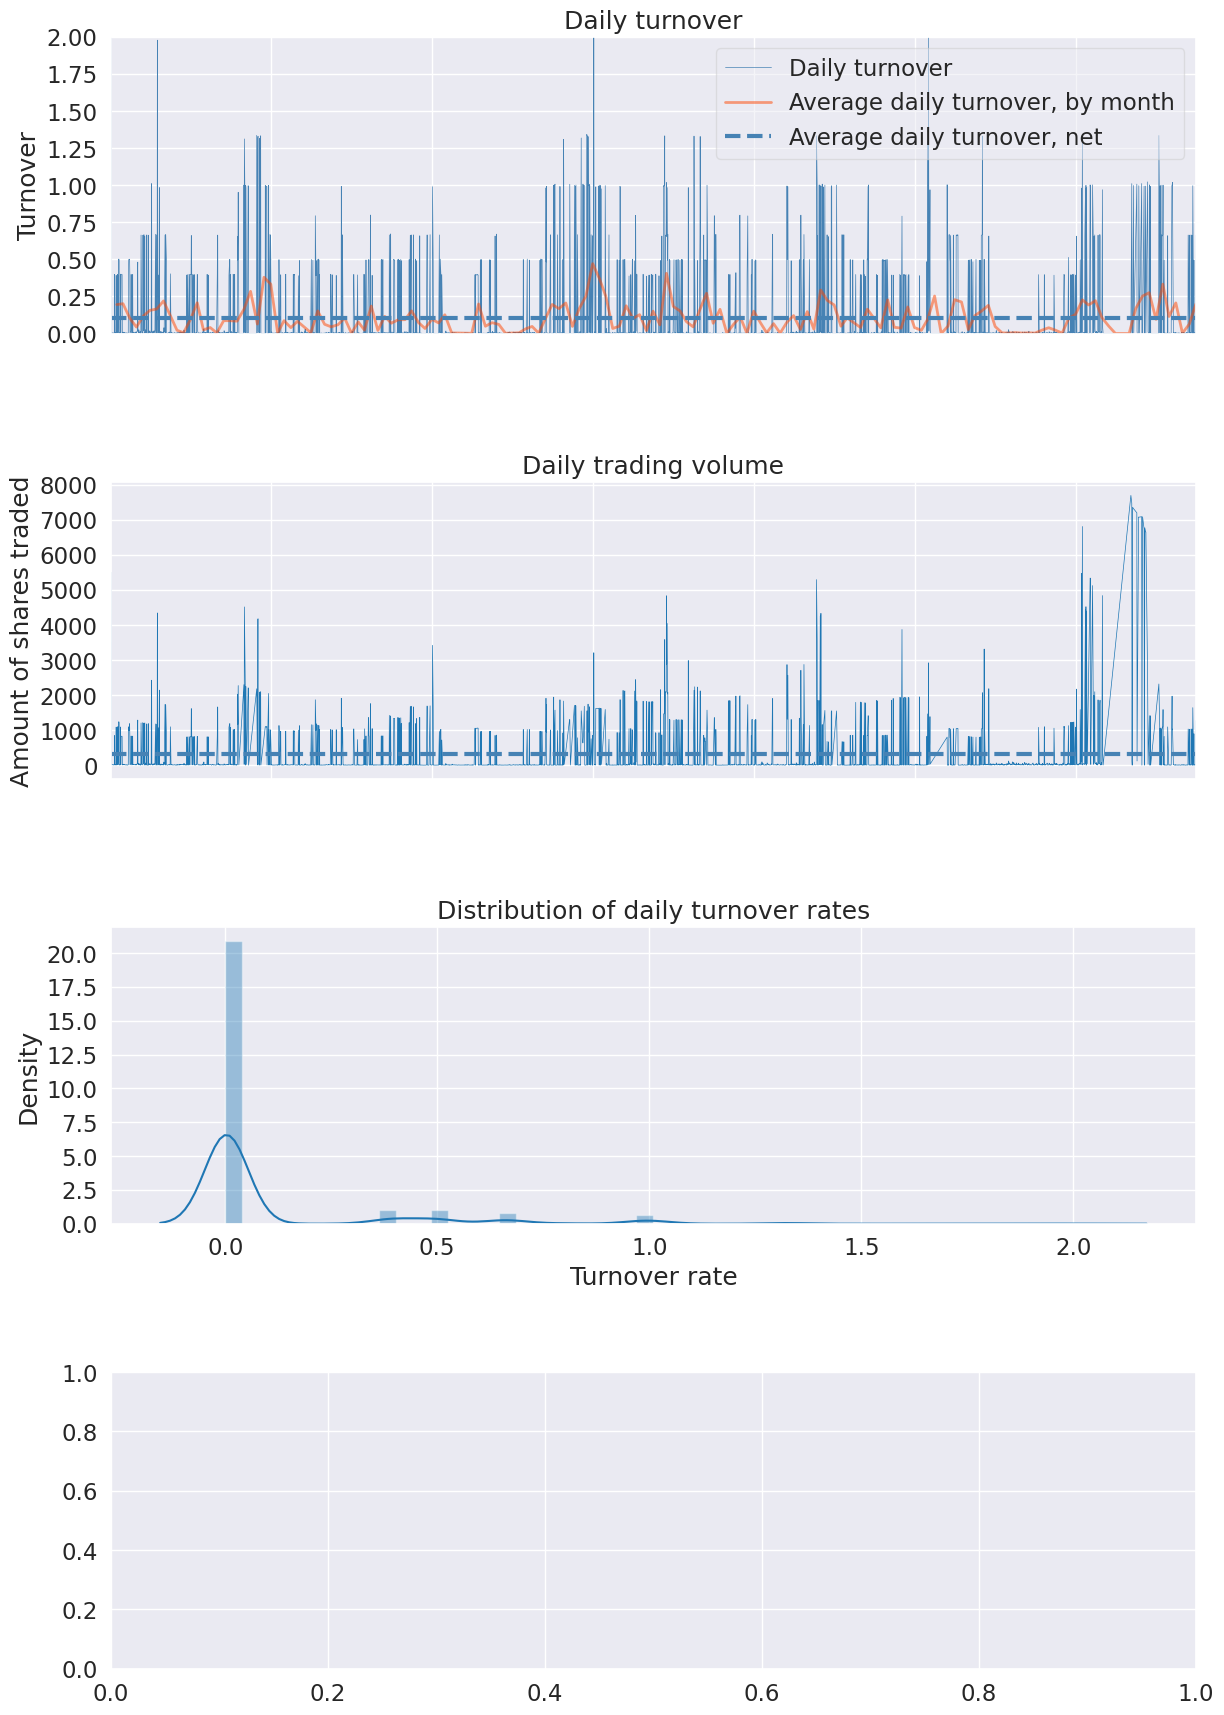

In [24]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)


pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    round_trips=True,
)